In [7]:
import torch
import lib.utils.bookkeeping as bookkeeping
from torch.utils.data import DataLoader
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import lib.models.models as models
import lib.models.model_utils as model_utils
from lib.datasets import mnist, maze, protein, synthetic
import lib.datasets.dataset_utils as dataset_utils
import lib.losses.losses as losses
import lib.losses.losses_utils as losses_utils
import lib.training.training as training
import lib.training.training_utils as training_utils
import lib.optimizers.optimizers as optimizers
import lib.optimizers.optimizers_utils as optimizers_utils
import lib.sampling.sampling as sampling
import lib.sampling.sampling_utils as sampling_utils
import os
from ruamel.yaml.scalarfloat import ScalarFloat

In [8]:
# creating paths
path = 'SavedModels/MAZEunet/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-12-20' # 2
config_name = 'config_001_unet8Mlogits.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_109999.pt' #  model_299999_hollowMLEProb.pt

path = 'SavedModels/BIN-MNIST/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-12-17' # 2
config_name = 'config_001_unet3M.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_199999_unet3M.pt' 

path = 'SavedModels/Synthetic/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-12-18' # 2
config_name = 'config_001_hollowrelbo.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_199999_hollowrelbo.pt'

path = 'SavedModels/MNIST/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-12-20' # 2
config_name = 'config_001_unet14Mlogits.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_349999.pt'

# creating paths
path = 'SavedModels/MAZE/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-12-20' # 2
config_name = 'config_001_hollow8M.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_79999.pt' #  model_299999_hollowMLEProb.pt

path = 'SavedModels/MAZEunet/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-12-20' # 2
config_name = 'config_001_unet8Mlogits.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_109999.pt' #  model_299999_hollowMLEProb.pt

path = 'SavedModels/Synthetic/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-12-20' # 2
config_name = 'config_001_hollowCEProb500K.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_9999_hollowCEProb500K.pt'


#config_name = 'config_001_r07.yaml' 
#model_name = 'model_84999_hollowr07.pt' 
config_path = os.path.join(path, date, config_name)
checkpoint_path = os.path.join(path, date, model_name)

In [9]:
# creating models
cfg = bookkeeping.load_config(config_path)
cfg.sampler.name = 'CRMLBJF' #ExactSampling' # ElboLBJF CRMTauL CRMLBJF
cfg.sampler.num_corrector_steps = 0
cfg.sampler.corrector_entry_time = ScalarFloat(0.0)
cfg.sampler.num_steps = 500
cfg.sampler.is_ordinal = False

#print(cfg)
device = torch.device(cfg.device)

model = model_utils.create_model(cfg, device)
print("number of parameters: ", sum([p.numel() for p in model.parameters()]))

#modified_model_state = utils.remove_module_from_keys(loaded_state['model'])
#model.load_state_dict(modified_model_state)
#optimizer = optimizers_utils.get_optimizer(model.parameters(), cfg)
optimizer = torch.optim.Adam(model.parameters(), cfg.optimizer.lr)

sampler = sampling_utils.get_sampler(cfg)

state = {"model": model, "optimizer": optimizer, "n_iter": 0}
state = bookkeeping.load_state(state, checkpoint_path)
state['model'].eval()

number of parameters:  596610
ema state dict function


In [10]:
n_samples = 1000
samples, changes = sampler.sample(model, n_samples)
saved_samples = samples

500it [00:36, 13.70it/s]


remapping binary repr with gray code
{'0000000000000000': '0000000000000000', '1000000000000000': '1000000000000000', '0000000000000001': '0000000000000001', '1000000000000001': '1000000000000001', '0000000000000011': '0000000000000010', '1000000000000011': '1000000000000010', '0000000000000010': '0000000000000011', '1000000000000010': '1000000000000011', '0000000000000110': '0000000000000100', '1000000000000110': '1000000000000100', '0000000000000111': '0000000000000101', '1000000000000111': '1000000000000101', '0000000000000101': '0000000000000110', '1000000000000101': '1000000000000110', '0000000000000100': '0000000000000111', '1000000000000100': '1000000000000111', '0000000000001100': '0000000000001000', '1000000000001100': '1000000000001000', '0000000000001101': '0000000000001001', '1000000000001101': '1000000000001001', '0000000000001111': '0000000000001010', '1000000000001111': '1000000000001010', '0000000000001110': '0000000000001011', '1000000000001110': '1000000000001011', '0

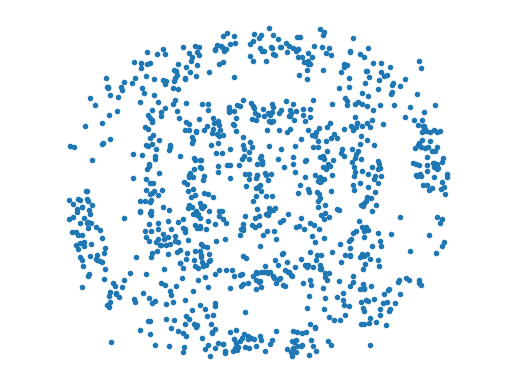

In [11]:
is_img = cfg.data.is_img

if is_img:
    samples = samples.reshape(n_samples, 1, cfg.data.image_size, cfg.data.image_size)
    saving_train_path = os.path.join(cfg.saving.sample_plot_path, f"{cfg.model.name}{state['n_iter']}_{cfg.sampler.name}{cfg.sampler.num_steps}.png")
    fig = plt.figure(figsize=(9, 9)) 
    for i in range(n_samples):
        plt.subplot(int(np.sqrt(n_samples)), int(np.sqrt(n_samples)), 1 + i)
        plt.axis("off")
        plt.imshow(np.transpose(samples[i, ...], (1,2,0)), cmap="gray")
 
 
    plt.savefig(saving_train_path)
    plt.show()
    plt.close()
else:
    bm, inv_bm = synthetic.get_binmap(cfg.model.concat_dim, cfg.data.binmode)
    print(inv_bm)
    samples = synthetic.bin2float(samples.astype(np.int32), inv_bm, cfg.model.concat_dim, cfg.data.int_scale)

 
    saving_plot_path = os.path.join(path, f"{cfg.model.name}{state['n_iter']}_{cfg.sampler.name}{cfg.sampler.num_steps}.png")
    saving_np_path = os.path.join(path, f"samples_{cfg.model.name}{state['n_iter']}_{cfg.sampler.name}{cfg.sampler.num_steps}.npy")
    np.save(f'{saving_np_path}', samples)

    #aving_plot_path = '/Users/paulheller/PythonRepositories/Master-Thesis/ContTimeDiscreteSpace/TAUnSDDM/SavedModels/MNIST/'
    synthetic.plot_samples(samples, saving_plot_path, im_size=cfg.data.plot_size, im_fmt="png")

[0.7853125333786011, 0.056968752294778824, 0.04087500274181366, 0.03425000235438347, 0.028218751773238182, 0.02562500163912773, 0.023468751460313797, 0.02121875062584877, 0.020000001415610313, 0.018187500536441803, 0.018250001594424248, 0.016562500968575478, 0.016375001519918442, 0.01612500101327896, 0.01575000025331974, 0.014281250536441803, 0.014625000767409801, 0.011812500655651093, 0.01353125087916851, 0.013093750923871994, 0.012656250968575478, 0.012312500737607479, 0.012218751013278961, 0.010656250640749931, 0.011218750849366188, 0.011312500573694706, 0.011562500149011612, 0.010593750514090061, 0.010093750432133675, 0.010156250558793545, 0.010343750938773155, 0.00950000062584877, 0.010125000029802322, 0.009812500327825546, 0.010156250558793545, 0.009781250730156898, 0.008875000290572643, 0.009968750178813934, 0.009156250394880772, 0.010281250812113285, 0.008781250566244125, 0.008531250059604645, 0.00793750025331974, 0.007906250655651093, 0.008218750357627869, 0.008281250484287739

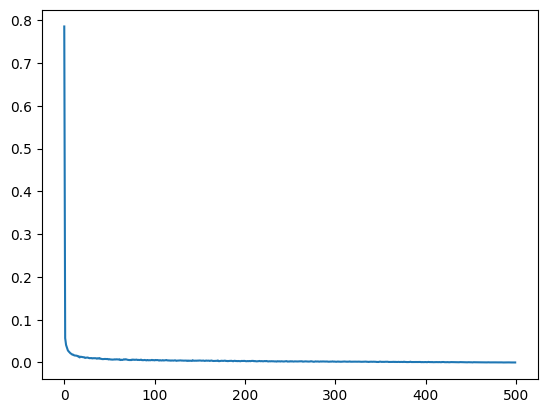

In [12]:
plt.plot(changes)
print(changes)
plt.show()